### *Predicting Popular Tags Using Title Data on StackOverflow!*


This is where I got the dataset: https://www.brentozar.com/archive/2015/10/how-to-download-the-stack-overflow-database-via-bittorrent/

I mainly used the as of 2010 dataset, but keep in mind this can be scaled to a higher or lower amount. 

Also be aware the train_test_split takes up a lot of ram if you let it so I pickle the data. 
You can also increase the size of your paging file if you don't have enough ram.

Feel free to disable classifiers that might run poorly just as proof of concept like the random forest with 1000 trees.

The tests were done on a computer with 32 threads hence the n_jobs=32 parameter

The gride search probably doesn't need 100 folds either as it preforms simially with a lot less strain at 15, but I thought it was fun to just push it. 

## THE SQL SECTION 

Here is some code to turn an SQL database into CSV files.

```
create function [dbo].[GetString]
(
@value as nvarchar(max)
)
returns nvarchar(max)
as
begin
return case when @value is null then 'null' when @value = '' then '""' else '"'+ replace(@value,'"','""""') + '"' end
end

-- SQL varbinary to bytea postgresql
-- master.dbo.fn_varbintohexstr
-- encode(decode('68656C6C6F','hex'),'escape')
--Schema script
declare @databaseName varchar(100)

set @databaseName = DB_NAME()

select 'create schema ' + name + '; ALTER SCHEMA public OWNER TO postgres;'
from sys.schemas
where name not like 'db[_]%'
	and name <> 'sys'
	and name <> 'INFORMATION_SCHEMA'

--Table script
select cast('create table ' + TABLE_SCHEMA + '.' + table_name + char(13) + '(' + STUFF((
				select ', ' + char(13) + column_name + (
						case 
							when DATA_TYPE in (
									'nvarchar'
									,'varchar',
									'char',
									'nchar'
									)
								and CHARACTER_MAXIMUM_LENGTH <> - 1 and CHARACTER_MAXIMUM_LENGTH < 8000
								then ' varchar(' + cast(isnull(CHARACTER_MAXIMUM_LENGTH, 8000) as varchar(10)) + ')'
							when DATA_TYPE in (
									'nvarchar'
									,'text'
									,'varchar',
									'char',
									'nchar',
									'ntext'
									)
								or CHARACTER_MAXIMUM_LENGTH = - 1
								then ' text'
							when DATA_TYPE = 'decimal'
								then ' Numeric(' + cast(NUMERIC_PRECISION as varchar(2)) + ',' + cast(numeric_scale as varchar(2)) + ')'
							when DATA_TYPE = 'bit'
								then ' Boolean' + iif(COLUMN_DEFAULT = '((0))', ' Default false', iif(COLUMN_DEFAULT = '((1))', ' Default true', ''))
							when DATA_TYPE = 'tinyint'
								then ' smallint' + iif(COLUMN_DEFAULT is not null, ' Default ' + replace(replace(COLUMN_DEFAULT, '((', ''), '))', ''), '')
							when DATA_TYPE = 'date'
								then ' date'
							when DATA_TYPE = 'datetime'
								or DATA_TYPE = 'datetime2'
								then ' timestamptz'
							when DATA_TYPE = 'uniqueidentifier'
								then ' UUID'
							when DATA_TYPE in (
									'money'
									,'smallmoney'
									)
								then ' Numeric(8,2)'
							when DATA_TYPE in (
									'binary'
									,'varbinary'
									,'image'
									)
								then ' BYTEA'
							else ' ' + case COLUMNPROPERTY(OBJECT_ID(TABLE_SCHEMA + '.' + TABLE_NAME), COLUMN_NAME, 'IsIdentity')
									when 1
										then 'SERIAL'
									else DATA_TYPE
									end
							end
						)
				from INFORMATION_SCHEMA.COLUMNS
				where (
						table_name = Results.table_name
						and TABLE_SCHEMA = Results.TABLE_SCHEMA
						)
				for xml PATH('')
					,TYPE
				).value('(./text())[1]', 'VARCHAR(MAX)'), 1, 2, '') + char(13) + ');' + char(13) as xml)
from INFORMATION_SCHEMA.COLUMNS Results
where TABLE_NAME not in (
		select [name]
		from sys.views
		)
group by Results.TABLE_SCHEMA
	,table_name
for xml PATH('')

declare @databaseName varchar(100)
declare @folderPath varchar(100)='C:\data_project3'
set @databaseName = DB_NAME()


--Export query prepration
select ROW_NUMBER() over (
		order by (
				select 1
				)
		) rownum
	,'select * FROM ' + @databaseName + '.' + '[' + SCHEMA_NAME(schema_id) + '].[' + t.name + ']' as col1
	,'select ' + STUFF((
			select ',' + case 
					when DATA_TYPE = 'datetime'
						or DATA_TYPE = 'datetime2'
						then ' Isnull(nullif(convert(nvarchar(28),' + COLUMN_NAME + + ' ,121) ,' + char(39) + char(39) + '), ' + char(39) + 'null' + char(39) + ')'
					when DATA_TYPE = 'varchar'
						or DATA_TYPE = 'nvarchar'
						then @databaseName + '.dbo.GetString(' + COLUMN_NAME + ')'
					when DATA_TYPE = 'binary'
						or DATA_TYPE = 'varbinary'
						or DATA_TYPE = 'image'
						then 'substring(master.dbo.fn_varbintohexstr(' + COLUMN_NAME + '), 3, len(master.dbo.fn_varbintohexstr(' + COLUMN_NAME + ')))'
					else ' Isnull(nullif(cast(' + COLUMN_NAME + + ' as nvarchar(max)) ,' + char(39) + char(39) + '), ' + char(39) + 'null' + char(39) + ')'
					end
			from INFORMATION_SCHEMA.COLUMNS
			where TABLE_NAME = t.name
				and TABLE_SCHEMA = schema_name(schema_id)
			order by table_schema
				,table_name
				,ordinal_position
			for xml PATH('')
			), 1, 1, '') + ' FROM ' + @databaseName + '.' + '[' + SCHEMA_NAME(schema_id) + '].[' + t.name + ']' as col2
	,SCHEMA_NAME(schema_id) + '."' + t.name + '"' as col3
into tempQueries
from sys.tables t

select * into  tempQueriesCopy from tempQueries
--Export with bcp script
declare @query1 varchar(MAX)
declare @query2 varchar(MAX)
declare @table varchar(MAX)
declare @row int = 0

while exists (
		select top 1 rownum
		from tempQueries
		)
begin
	select top 1 @query1 = col2
		,@query2 = col2
		,@row = rownum
		,@table = col3
	from tempQueries

	declare @sql varchar(8000) = ''

	select @sql = 'bcp "' + @query2 + '" queryout "' + @folderPath + replace( @table,'"','') + '.csv" -c -t~ -T -S' + @@servername

	print @sql

	exec master..xp_cmdshell @sql

	delete
	from tempQueries
	where rownum = @row
end


---- To allow advanced options to be changed.  
--EXEC sp_configure 'show advanced options', 1;  
--GO  
---- To update the currently configured value for advanced options.  
--RECONFIGURE;  
--GO  
---- To enable the feature.  
--EXEC sp_configure 'xp_cmdshell', 1;  
--GO  
---- To update the currently configured value for this feature.  
--RECONFIGURE;  
--GO  

```

Since we are using MS SQL we can use MS SQL Server Mangement Studio to make a CSV also 

Keep in mind that the title data has commas in it so you will have to remove the commas 

Here is some example code to do that

```

update [StackOverflow2010].[dbo].[Posts] set Tags = REPLACE(Tags,',',' ')
update [StackOverflow2010].[dbo].[Posts] set Title = REPLACE(Title,',',' ')
update [StackOverflow2010].[dbo].[Posts] set Body = REPLACE(Body,',',' ')
update [StackOverflow2010].[dbo].[Posts] set Tags = REPLACE(Tags,'>',' ')
update [StackOverflow2010].[dbo].[Posts] set Tags = REPLACE(Tags,'<',' ')

```

The code above will also remove the <> from the tags as it is in html format.

I also removed data that didn't have a title too.

```

DELETE FROM [StackOverflow2010].[dbo].[Posts]
WHERE Title IS NULL;

SELECT TOP (400000) '"' + cast(Title as varchar(250)) + '"' as Title, '"' + cast(Tags as varchar(250)) + '"' as Tags
FROM [StackOverflow2010].[dbo].[Posts];

```

If you decide to import it as an excel sheet please be aware of the 1,048,576 rows by 16,384 columns limit.

If you are using the SQL Server Import and Export Wizard and want to add a "quote" Text Qualifer you may need to run this:

```

SET QUOTED_IDENTIFIER OFF

```

### THE PYTHON SECTION 

In [1]:
# Wow honestly I should just import all of sklearn while I'm at it

import pandas as pd
from pyarrow import csv
import nltk as nltk
from bs4 import BeautifulSoup 
import pyarrow as pa
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from dask.diagnostics import ProgressBar
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import export_graphviz
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import hamming_loss
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import pickle

In [2]:
# My collection of fun classifiers

dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
tree = tree.DecisionTreeClassifier()
knn = KNeighborsClassifier(n_jobs=32)
rfc10 = RandomForestClassifier(n_estimators=1000, n_jobs=32) # 10 Trees
rfc100 = RandomForestClassifier(n_estimators=1000, n_jobs=32) # 100 Trees
rfc1000 = RandomForestClassifier(n_estimators=1000, n_jobs=32) # 1000 Trees

In [3]:
# Reading the CSV and we gotta use ISO-8859-1 because of the unicode 

df = pd.read_csv("C:\data_project3\CSVfile.csv", encoding="ISO-8859-1")

In [4]:
df.head()

,Tags,Title,Score,ViewCount
0,c# floating-point type-conversion double d...,Convert Decimal to Double?,573,37080
1,html css css3 internet-explorer-7,Percentage width child element in absolutely p...,256,16306
2,c# .net datetime,How do I calculate someone's age in C#?,1743,480476
3,c# datetime time datediff relative-time-span,Calculate relative time in C#,1348,136033
4,javascript html browser timezone timezoneo...,Determine a User's Timezone,539,157009


In [5]:
# One milllllllionnnnnn

df.shape

(1000000, 4)

In [6]:
df.dtypes

Tags         object
Title        object
Score         int64
ViewCount     int64
dtype: object

In [7]:
# Down to 28k just from this alone

df = df[df['Score']>50]
df.shape

(28183, 4)

In [8]:
df = df[df['ViewCount']>10000]
df.shape

(27666, 4)

In [9]:
df['Tags'] = df['Tags'].astype(str)
df.dtypes

Tags         object
Title        object
Score         int64
ViewCount     int64
dtype: object

In [10]:
df['Tags'] = df['Tags'].apply(lambda x: x.split())

In [11]:
# This is the total number of tags!

all_tags = [item for sublist in df['Tags'].values for item in sublist]
len(all_tags)

82516

In [12]:
# This is the total number of unique tags!

my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

6884

In [13]:
flat = [item for sublist in df['Tags'].values for item in sublist]
words = nltk.FreqDist(flat)
words = nltk.FreqDist(words)
freq_words = words.most_common(100)
features = [word[0] for word in freq_words]
features

['c#',
 'java',
 'javascript',
 'python',
 '.net',
 'c++',
 'jquery',
 'php',
 'android',
 'html',
 'sql',
 'git',
 'css',
 'string',
 'c',
 'mysql',
 'sql-server',
 'iphone',
 'ruby',
 'objective-c',
 'linux',
 'arrays',
 'asp.net',
 'ruby-on-rails',
 'bash',
 'windows',
 'database',
 'visual-studio',
 'performance',
 'ios',
 'eclipse',
 'regex',
 'wpf',
 'asp.net-mvc',
 'django',
 'algorithm',
 'shell',
 'vim',
 'multithreading',
 'tsql',
 'cocoa-touch',
 'xml',
 'datetime',
 'svn',
 'oop',
 'json',
 'list',
 'unix',
 'file',
 'linq',
 'unit-testing',
 'language-agnostic',
 'version-control',
 'http',
 'debugging',
 'date',
 'command-line',
 'generics',
 'r',
 'syntax',
 'exception',
 'macos',
 'reflection',
 'winforms',
 'postgresql',
 'ajax',
 'math',
 'class',
 'dictionary',
 'function',
 'sorting',
 'security',
 'design-patterns',
 'cocoa',
 'collections',
 'url',
 'image',
 'enums',
 'scala',
 'oracle',
 'xcode',
 'html5',
 'coding-style',
 'sql-server-2005',
 'visual-studio-200

In [14]:
def top_tags (tags):
    filter = []
    for i in range(0, len(tags)):
        if tags[i] in features:
            filter.append(tags[i])
    return filter

In [15]:
df['Tags'] = df['Tags'].apply(lambda x: top_tags (x))
df['Tags'] = df['Tags'].apply(lambda x: x if len(x)>0 else None)
df.shape

(27666, 4)

In [16]:
df.dropna(subset=['Tags'], inplace=True)
df.shape

(25352, 4)

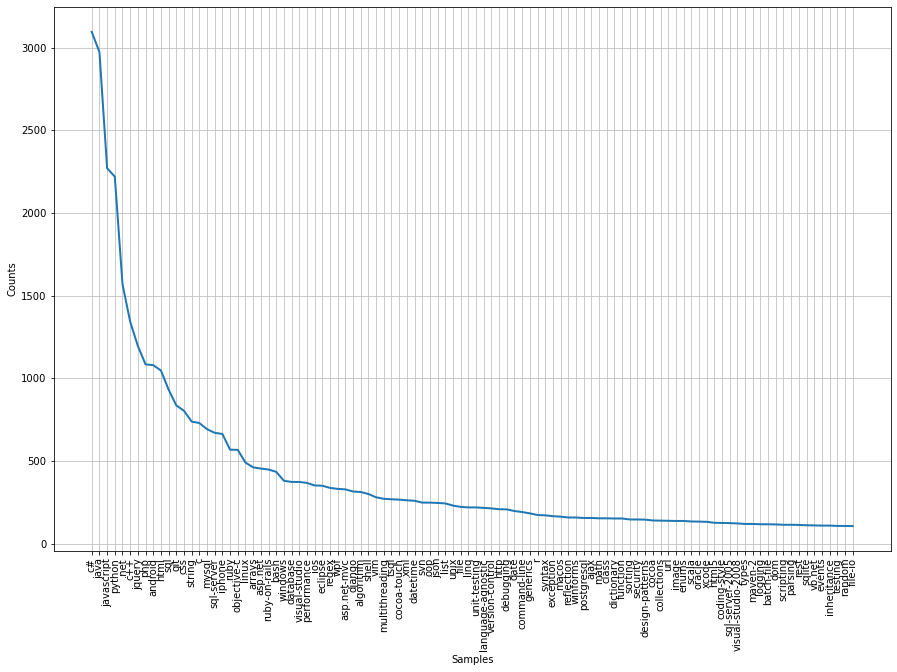

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
words.plot(100, cumulative=False)

In [18]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [19]:
token = nltk.ToktokTokenizer()

In [20]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [21]:
def clean_punct(text): 
    words=token.tokenize(text)
    punct_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in features:
            punct_filtered.append(w)
        else:
            punct_filtered.append(regex.sub('', w))
  
    filter_list = strip_list_noempty(punct_filtered)
        
    return ' '.join(map(str, filter_list))

In [22]:
df['Title'] = df['Title'].apply(lambda x: clean_punct(x)) 
df.head()

,Tags,Title,Score,ViewCount
0,[c#],Convert Decimal to Double,573,37080
1,"[html, css]",Percentage width child element in absolutely p...,256,16306
2,"[c#, .net, datetime]",How do I calculate someone s age in C,1743,480476
3,"[c#, datetime]",Calculate relative time in C,1348,136033
4,"[javascript, html]",Determine a User s Timezone,539,157009


In [23]:
nltk.download('stopwords')
nltk.download('wordnet')
lemma = nltk.WordNetLemmatizer()
stop = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lanzc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lanzc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop]
    
    return ' '.join(map(str, filtered))

In [25]:
df['Title'] = df['Title'].apply(lambda x: lemitizeWords(x)) 
df['Title'] = df['Title'].apply(lambda x: stopWordsRemove(x)) 
df.head()

,Tags,Title,Score,ViewCount
0,[c#],Convert Decimal Double,573,37080
1,"[html, css]",Percentage width child element absolutely posi...,256,16306
2,"[c#, .net, datetime]",How I calculate someone age C,1743,480476
3,"[c#, datetime]",Calculate relative time C,1348,136033
4,"[javascript, html]",Determine User Timezone,539,157009


In [26]:
x = df['Title']
y = df['Tags']

In [27]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [28]:
# Making the title stuff into actual data

vectorizer = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)
tfidf = vectorizer.fit_transform(x)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(tfidf, y_bin, test_size = 0.2, random_state = 0)

In [30]:
# This is some pickle stuff - not needed but use it if ur gonna run this a lot

filename1 = 'x_train_pickle'
outfile1 = open(filename1,'wb')

filename2 = 'x_test_pickle'
outfile2 = open(filename2,'wb')

filename3 = 'y_train_pickle'
outfile3 = open(filename3,'wb')

filename4 = 'y_test_pickle'
outfile4 = open(filename4,'wb')

In [31]:
pickle.dump(x_train,outfile1)
outfile1.close()

pickle.dump(x_test,outfile2)
outfile2.close()

pickle.dump(y_train,outfile3)
outfile3.close()

pickle.dump(y_test,outfile4)
outfile4.close()

In [32]:
def avg_jacard(y_true,y_pred):

    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Classifier: ", clf.__class__.__name__)
    print("Jacard Distance: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming Loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("\n")

In [33]:
for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac, tree, knn, rfc10, rfc100, rfc1000]: # add or remove rfc 10-1000 for better or worse performance
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print_score(y_pred, classifier)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


Classifier:  DummyClassifier
Jacard Distance: 2.5727761031448666
Hamming Loss: 3.140800631039243


Classifier:  SGDClassifier
Jacard Distance: 45.72832445934398
Hamming Loss: 1.0228751725497929


Classifier:  LogisticRegression
Jacard Distance: 41.08558469729836
Hamming Loss: 1.0932754880694144


Classifier:  MultinomialNB
Jacard Distance: 23.167356865838425
Hamming Loss: 1.3512127785446657


Classifier:  LinearSVC
Jacard Distance: 47.7634260172221
Hamming Loss: 1.0175507789390652


Classifier:  Perceptron
Jacard Distance: 42.677479787024254
Hamming Loss: 1.6992703608755668


Classifier:  PassiveAggressiveClassifier
Jacard Distance: 48.49621094740401
Hamming Loss: 1.1855649773220271


Classifier:  DecisionTreeClassifier
Jacard Distance: 43.10631884384596
Hamming Loss: 1.410964306842832


Classifier:  KNeighborsClassifier
Jacard Distance: 24.218431604548744
Hamming Loss: 1.42358509169789


Classifier:  RandomForestClassifier
Jacard Distance: 45.93669887596135
Hamming Loss: 1.07335831197

In [34]:
def print_top10(feature_names, clf, class_labels):

    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [35]:
param_grid = {'estimator__C':[1,10,100,1000]
              }

In [36]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 100, verbose=10, n_jobs=32, scoring = make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(x_train, y_train)

Fitting 100 folds for each of 4 candidates, totalling 400 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    4.5s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed:   10.1s
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:   12.8s
[Parallel(n_jobs=32)]: Done  81 tasks      | elapsed:   15.2s
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:   18.6s
[Parallel(n_jobs=32)]: Done 117 tasks      | elapsed:   27.4s
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   37.8s
[Parallel(n_jobs=32)]: Done 157 tasks      | elapsed:   39.8s
[Parallel(n_jobs=32)]: Done 178 tasks      | elapsed:   49.7s
[Parallel(n_jobs=32)]: Done 201 tasks      | elapsed:  1.2min
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:  1.3min
[Parallel(n_jobs=32)]: Done 249 tasks      | elapsed:  1.7min
[Parallel(n_jobs=32)]: Done 274 tasks      | elapsed:  

GridSearchCV(cv=100, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             n_jobs=32, param_grid={'estimator__C': [1, 10, 100, 1000]},
             scoring=make_scorer(avg_jacard), verbose=10)

In [37]:
CV_svc.best_params_

{'estimator__C': 1}

In [38]:
best_model = CV_svc.best_estimator_

In [39]:
y_pred = best_model.predict(x_test)

print_score(y_pred, best_model)

Classifier:  OneVsRestClassifier
Jacard Distance: 47.7634260172221
Hamming Loss: 1.0175507789390652




In [40]:
feature_names = vectorizer.get_feature_names()

In [41]:
print_top10(feature_names, best_model, multilabel_binarizer.classes_)

.net: 30 linq delegate nullable wcf forms assembly 40 .net net
ajax: underscore fetch json request google status prompt reason 2008 ajax
algorithm: detecting big finding area number graph binary sort tree algorithm
android: device layout emulator listview intent textview edittext webview activity android
arrays: duplicate arraylist options fill come do members native perl array
asp.net: ip datatable request cause onclick master session webconfig asp.net aspnet
asp.net-mvc: item render repository fire aspnet action controller partial asp.net mvc
bash: attach login export ssh recursive recursively stdout grep shell bash
batch-file: environment bite folders prompt built-in windows command script happen batch
c: consider unsigned char pointers gdb gcc struct pointer printf cc
c#: finally forms internal net generic nullable listt linq datatable c#
c++: const vector template qt virtual stl c++ boost cc std
class: nest does increment purpose struct modules particular self with class
cocoa: op

In [42]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    tn, fp, fn, tp = confusion_matrix(y_test[:,i], y_pred[:,i]).ravel()
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("True Negatives: ",tn)
    print("False Positives: ",fp)
    print("False Negatives: ",fn)
    print("True Positives: ",tp)
    print("Precision Score: ", precision_score(y_test[:,i], y_pred[:,i], average='weighted'))
    print("F1 Score: ", f1_score(y_test[:,i], y_pred[:,i], average='weighted'))
    print("Recall Score: ", recall_score(y_test[:,i], y_pred[:,i], average='weighted'))
    print("\n")

.net
[[4750   19]
 [ 225   77]]
True Negatives:  4750
False Positives:  19
False Negatives:  225
True Positives:  77
Precision Score:  0.9456804870008361
F1 Score:  0.939939558193612
Recall Score:  0.9518832577400907


ajax
[[5038    2]
 [  18   13]]
True Negatives:  5038
False Positives:  2
False Negatives:  18
True Positives:  13
Precision Score:  0.9956465448022053
F1 Score:  0.9953732177067588
Recall Score:  0.9960560047327943


algorithm
[[5002    1]
 [  51   17]]
True Negatives:  5002
False Positives:  1
False Negatives:  51
True Positives:  17
Precision Score:  0.9892973521839431
F1 Score:  0.9867901788570953
Recall Score:  0.9897456123052653


android
[[4833    4]
 [  58  176]]
True Negatives:  4833
False Positives:  4
False Negatives:  58
True Positives:  176
Precision Score:  0.9876632537654533
F1 Score:  0.9870101759675086
Recall Score:  0.9877736146716624


arrays
[[4971   19]
 [  33   48]]
True Negatives:  4971
False Positives:  19
False Negatives:  33
True Positives:  48


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



True Negatives:  5036
False Positives:  4
False Negatives:  22
True Positives:  9
Precision Score:  0.9937960619752485
F1 Score:  0.9938286316480662
Recall Score:  0.9948728061526326


eclipse
[[5005    1]
 [  11   54]]
True Negatives:  5005
False Positives:  1
False Negatives:  11
True Positives:  54
Precision Score:  0.9976020728934616
F1 Score:  0.9975361835592539
Recall Score:  0.9976336028396766


enums
[[5044    3]
 [   6   18]]
True Negatives:  5044
False Positives:  3
False Negatives:  6
True Positives:  18
Precision Score:  0.9981413908357059
F1 Score:  0.998166305862907
Recall Score:  0.9982252021297574


events
[[5047    1]
 [  18    5]]
True Negatives:  5047
False Positives:  1
False Negatives:  18
True Positives:  5
Precision Score:  0.9957063855801096
F1 Score:  0.9951581550043206
Recall Score:  0.9962532044961546


exception
[[5041    6]
 [  16    8]]
True Negatives:  5041
False Positives:  6
False Negatives:  16
True Positives:  8
Precision Score:  0.9948227026279097
F

 [   6   15]]
True Negatives:  5048
False Positives:  2
False Negatives:  6
True Positives:  15
Precision Score:  0.9983305384497331
F1 Score:  0.9983396826858006
Recall Score:  0.9984224018931177


reflection
[[5037    2]
 [  19   13]]
True Negatives:  5037
False Positives:  2
False Negatives:  19
True Positives:  13
Precision Score:  0.995424416846185
F1 Score:  0.9951133523329473
Recall Score:  0.995858804969434


regex
[[5007    1]
 [  30   33]]
True Negatives:  5007
False Positives:  1
False Negatives:  30
True Positives:  33
Precision Score:  0.9937526682472448
F1 Score:  0.9929818039859205
Recall Score:  0.9938868073358312


rest
[[5054    0]
 [   4   13]]
True Negatives:  5054
False Positives:  0
False Negatives:  4
True Positives:  13
Precision Score:  0.9992118247496853
F1 Score:  0.9991587703554672
Recall Score:  0.9992112009465589


ruby
[[4958    9]
 [  49   55]]
True Negatives:  4958
False Positives:  9
False Negatives:  49
True Positives:  55
Precision Score:  0.98753035